# `banyan v0`

In [381]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import mpl_toolkits as mpltk

In [382]:
nodes = 50
words = 100
ticks = 3000

To approximate a social network we use a graph generated with the Barabási–Albert model.

Each node is a person.
Each edge is an acquaintance.

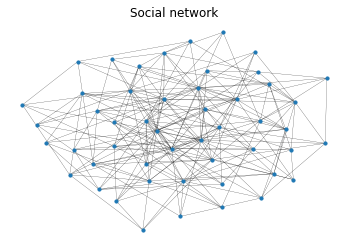

In [383]:
P = nx.barabasi_albert_graph(nodes, 5)

plt.gca().set_title('Social network')
nx.draw(
    P,
    pos=nx.kamada_kawai_layout(P),
    node_size=10,
    width=0.2,
)


The language lexicon is fixed and shared among people.

Each person can use each word with some degree of proficiency.

For the sake of simplicity, we assume the lexicon is ordered by word rank (i.e. lower indices constitute the "core" of the language). This also means that we can seed the proficiencies in accordance to the Zipfian laws by using a Pareto distribution.

In [384]:
for index in P.nodes:
    s = np.random.default_rng().pareto(5, words)
    s = s / max(s) * np.random.ranf()
    P.nodes[index]['lexicon'] = -np.sort(-s)

Each person has different levels of proficiency, but the distributions' shapes are qualitatively the same.

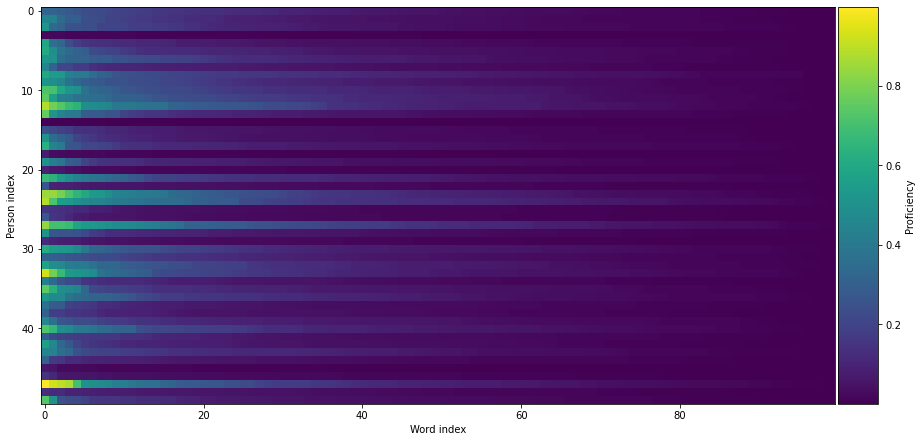

In [385]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot()
cax = mpltk.axes_grid1.make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)

im = ax.imshow(dict(P.nodes.data('lexicon')).values())
cb = plt.colorbar(im, cax=cax)

ax.set_xlabel('Word index')
ax.set_ylabel('Person index')
cb.set_label('Proficiency')
plt.show()

We run a simple simulation assuming communications happen sequentially along the directed edges.

The feedback function applied to the proficiencies is pretty naive.

In [386]:
history = np.zeros([ticks,nodes,words])

for tick in range(ticks):
    # pick a random edge and a random direction on it
    edge_index = np.random.randint(P.number_of_nodes())
    direction = np.random.choice([+1,-1], 1)[0]
    source_index, target_index = list(P.edges())[edge_index][::direction]
    
    # APPLY SOME KIND OF FEEDBACK TO THE LEXICONS
    source = P.nodes[source_index]['lexicon']
    target = P.nodes[target_index]['lexicon']
    P.nodes[target_index]['lexicon'] = target * (source / target) ** 0.1

    # push the new state to the history
    history[tick] = np.array(list(dict(P.nodes.data('lexicon')).values()))

The result is a population in which the best individuals forget while the worst learn.

Word proficiencies plateau, while people proficiencies converge to an average value.

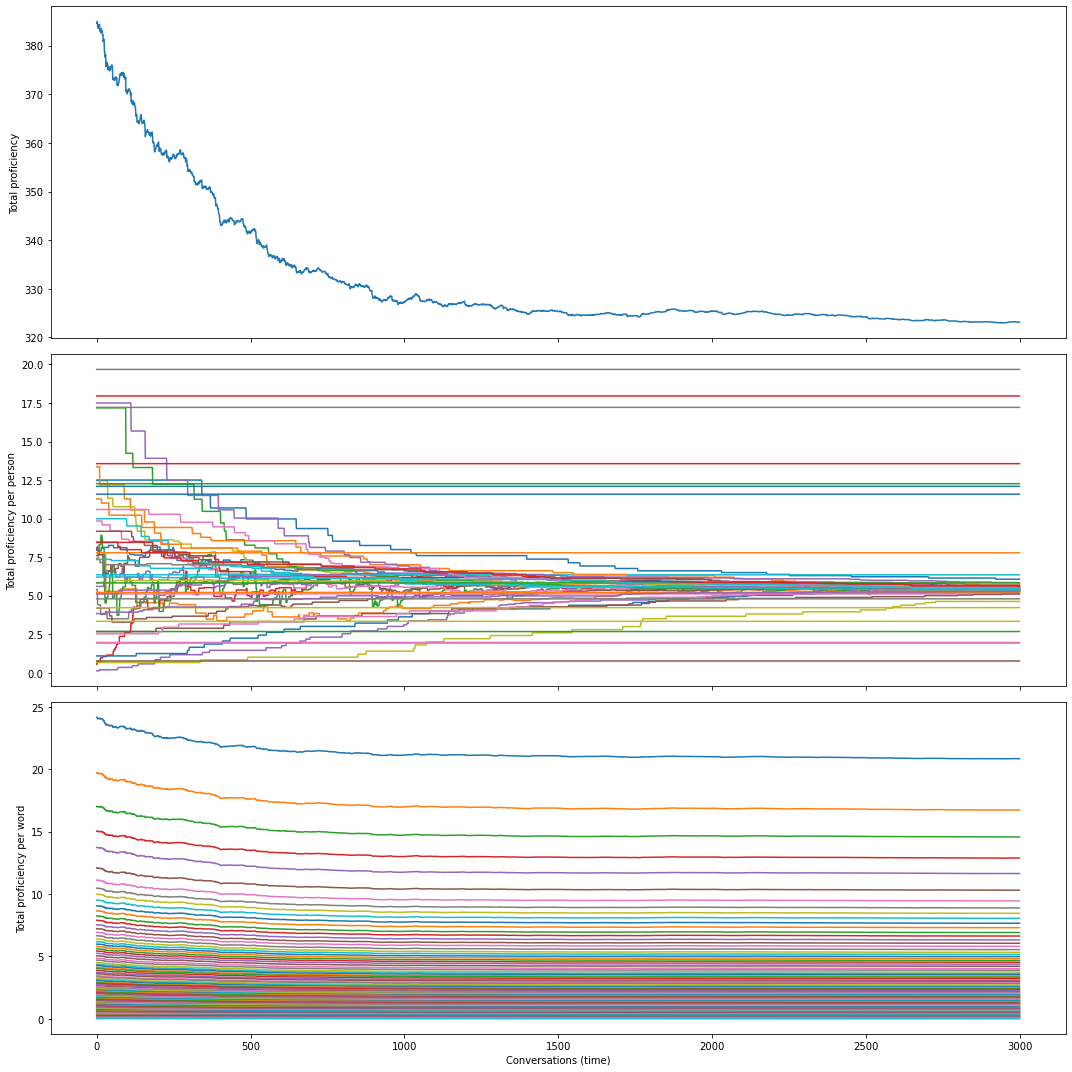

In [387]:
fig, axs = plt.subplots(3, sharex=True, figsize=(15,15))

axs[0].plot(np.sum(history, axis=(1,2)))
axs[1].plot(np.sum(history, axis=2))
axs[2].plot(np.sum(history, axis=1))

plt.xlabel('Conversations (time)')
axs[0].set_ylabel('Total proficiency')
axs[1].set_ylabel('Total proficiency per person')
axs[2].set_ylabel('Total proficiency per word')

plt.tight_layout()
plt.show()